In [1]:
import os

parent_directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
grandparent_directory = os.path.abspath(os.path.join(parent_directory, os.pardir))
os.sys.path.append(grandparent_directory)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import pickle as pkl

from tools.data_formatting import (
    get_smoothed_moving_all_data,
    get_common_indexes_n_recordings,
    smooth_tuning_curves_circularly,
    from_local_to_global_index,
)
from tools.data_manager import get_all_experiments_runs, get_fovs_given_animal
from tools.alignment import procrustes, canoncorr
from params import (
    order_experiments,
    get_colors_for_each_experiment,
    animals,
    root_dir,
    experiments_to_exclude,
)

# Load the sessions

In [2]:
### Load all sessions ###

animal = "m135"
fov = "fov1"
sessions = get_all_experiments_runs(animal, fov)
# Remove sessions to exclude
sessions = [session for session in sessions if session not in experiments_to_exclude]
# Create a mapping of sessions and their chronological order
order_map = {value: index for index, value in enumerate(order_experiments)}
sessions = sorted(sessions, key=lambda x: order_map[x])

# Load the cells with the global index and the tuning curves
all_cells = []
all_tuning_curves = []
for experiment, run in sessions:
    _, _, phi, cells, tuning_curves, _ = get_smoothed_moving_all_data(
        animal, fov, experiment, run
    )
    cells = from_local_to_global_index(animal, fov, (experiment, run), cells)
    all_cells.append(cells)
    all_tuning_curves.append(tuning_curves)

# Visualise the tuning curves before alignment

Cells in common: 84
... after removing flat tuning curves: 68


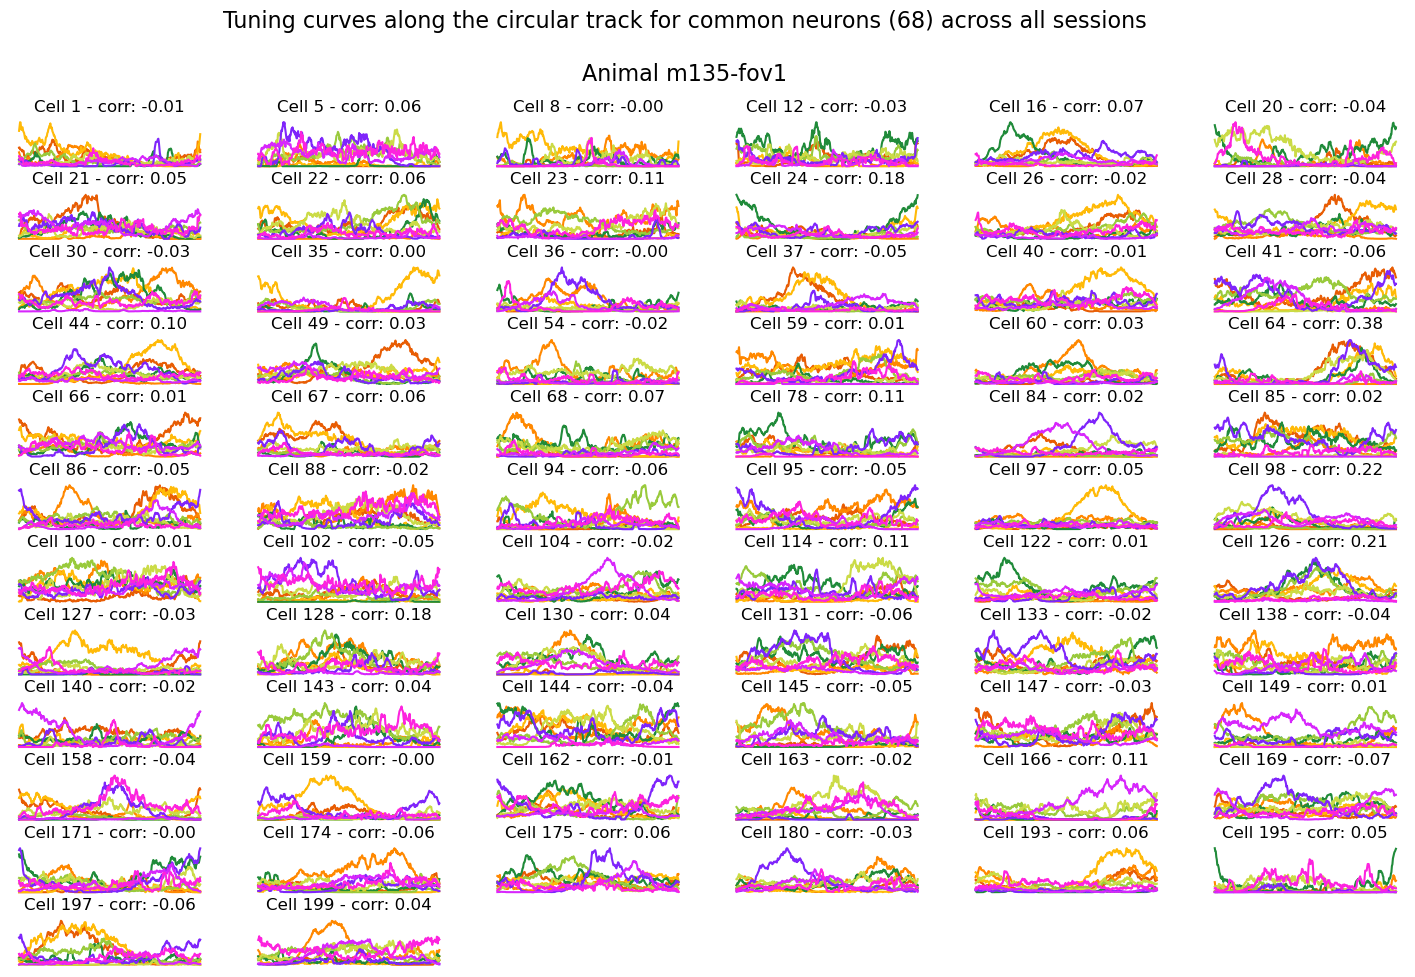

In [3]:
### Get the common cells and order all the tuning curves accordingly ###
sel_cells_masks, ordered_cells, common_neurons = get_common_indexes_n_recordings(
    all_cells
)
print(f"Cells in common: {len(ordered_cells[0])}")
# Remove the cells that are not common to all recordings
sel_tuning_curves = [
    tuning_curves[:, mask]
    for tuning_curves, mask in zip(all_tuning_curves, sel_cells_masks)
]
# Order all the cells such that indexes correspond to the same cell across all recordings
sel_tuning_curves = [
    tuning_curves[:, order]
    for tuning_curves, order in zip(sel_tuning_curves, ordered_cells)
]
# Smooth the tuning curves
smoothed_tuning_curves = [
    smooth_tuning_curves_circularly(tuning_curves, 10)
    for tuning_curves in sel_tuning_curves
]
# Check if any tuning curve is flat
neurons_with_flat_tuning_curves = []
for tuning_curves in smoothed_tuning_curves:
    for i, tuning_curve in enumerate(tuning_curves.T):
        if np.all(tuning_curve == tuning_curve[0]):
            neurons_with_flat_tuning_curves.append(i)
neurons_with_flat_tuning_curves = np.unique(neurons_with_flat_tuning_curves)
if len(neurons_with_flat_tuning_curves) > 0:
    # Remove neurons with flat tuning curves
    smoothed_tuning_curves = [
        np.delete(tuning_curves, neurons_with_flat_tuning_curves, axis=1)
        for tuning_curves in smoothed_tuning_curves
    ]
    common_neurons = np.delete(common_neurons, neurons_with_flat_tuning_curves)
    print(f"... after removing flat tuning curves: {len(common_neurons)}")

### Plot tuning curves of common neurons ###

n_cols = 6
colors = get_colors_for_each_experiment(sessions)
fig = plt.figure(figsize=(3 * n_cols, 1 * (len(common_neurons) // n_cols)))
grid = plt.GridSpec(
    nrows=np.ceil(len(common_neurons) / n_cols).astype(int),
    ncols=n_cols,
    figure=fig,
    wspace=0.2,
    hspace=0.5,
)
for n in range(len(common_neurons)):
    row = n // n_cols
    col = n % n_cols
    # save the tuning curves given the neuron to calculate their correlation
    tuning_curves = []
    ax = fig.add_subplot(grid[row, col])
    for s, session in enumerate(sessions):
        tuning_curves.append(smoothed_tuning_curves[s][:, n])
        ax.plot(
            np.arange(smoothed_tuning_curves[s].shape[0]),
            smoothed_tuning_curves[s][:, n],
            color=colors[s],
        )
    # find the correlation between the tuning curves
    correlations = []
    for i in range(len(tuning_curves)):
        for j in range(i + 1, len(tuning_curves)):
            corr = np.corrcoef(tuning_curves[i], tuning_curves[j])[0, 1]
            correlations.append(corr)
    ax.set_title(f"Cell {common_neurons[n]} - corr: {np.nanmean(correlations):.2f}")
    ax.set_axis_off()

fig.suptitle(
    f"Tuning curves along the circular track for common neurons ({len(common_neurons)}) across all sessions\n\nAnimal {animal}-{fov}",
    fontsize=16,
)
plt.savefig(f"{os.getcwd()}/plots/fig2b_1.pdf")
plt.savefig(f"{os.getcwd()}/plots/PNGs/fig2b_1.png", dpi=300)
plt.show()
# Save the data
with open(
    f"{grandparent_directory}/data/fig2/fig2b/{animal}_{fov}_pre_alignment_tuning_curves_common_neurons.pkl",
    "wb",
) as f:
    pkl.dump(
        {
            "tuning_curves": smoothed_tuning_curves,
            "common_neurons": common_neurons,
            "sessions": sessions,
        },
        f,
    )


# Align the manifolds using all the neurons
Project the neural activity from each session onto the space of the first session. Look at the neurons that were common at all the sessions. 

Reference session with 209 neurons
... after removing flat tuning curves: 20


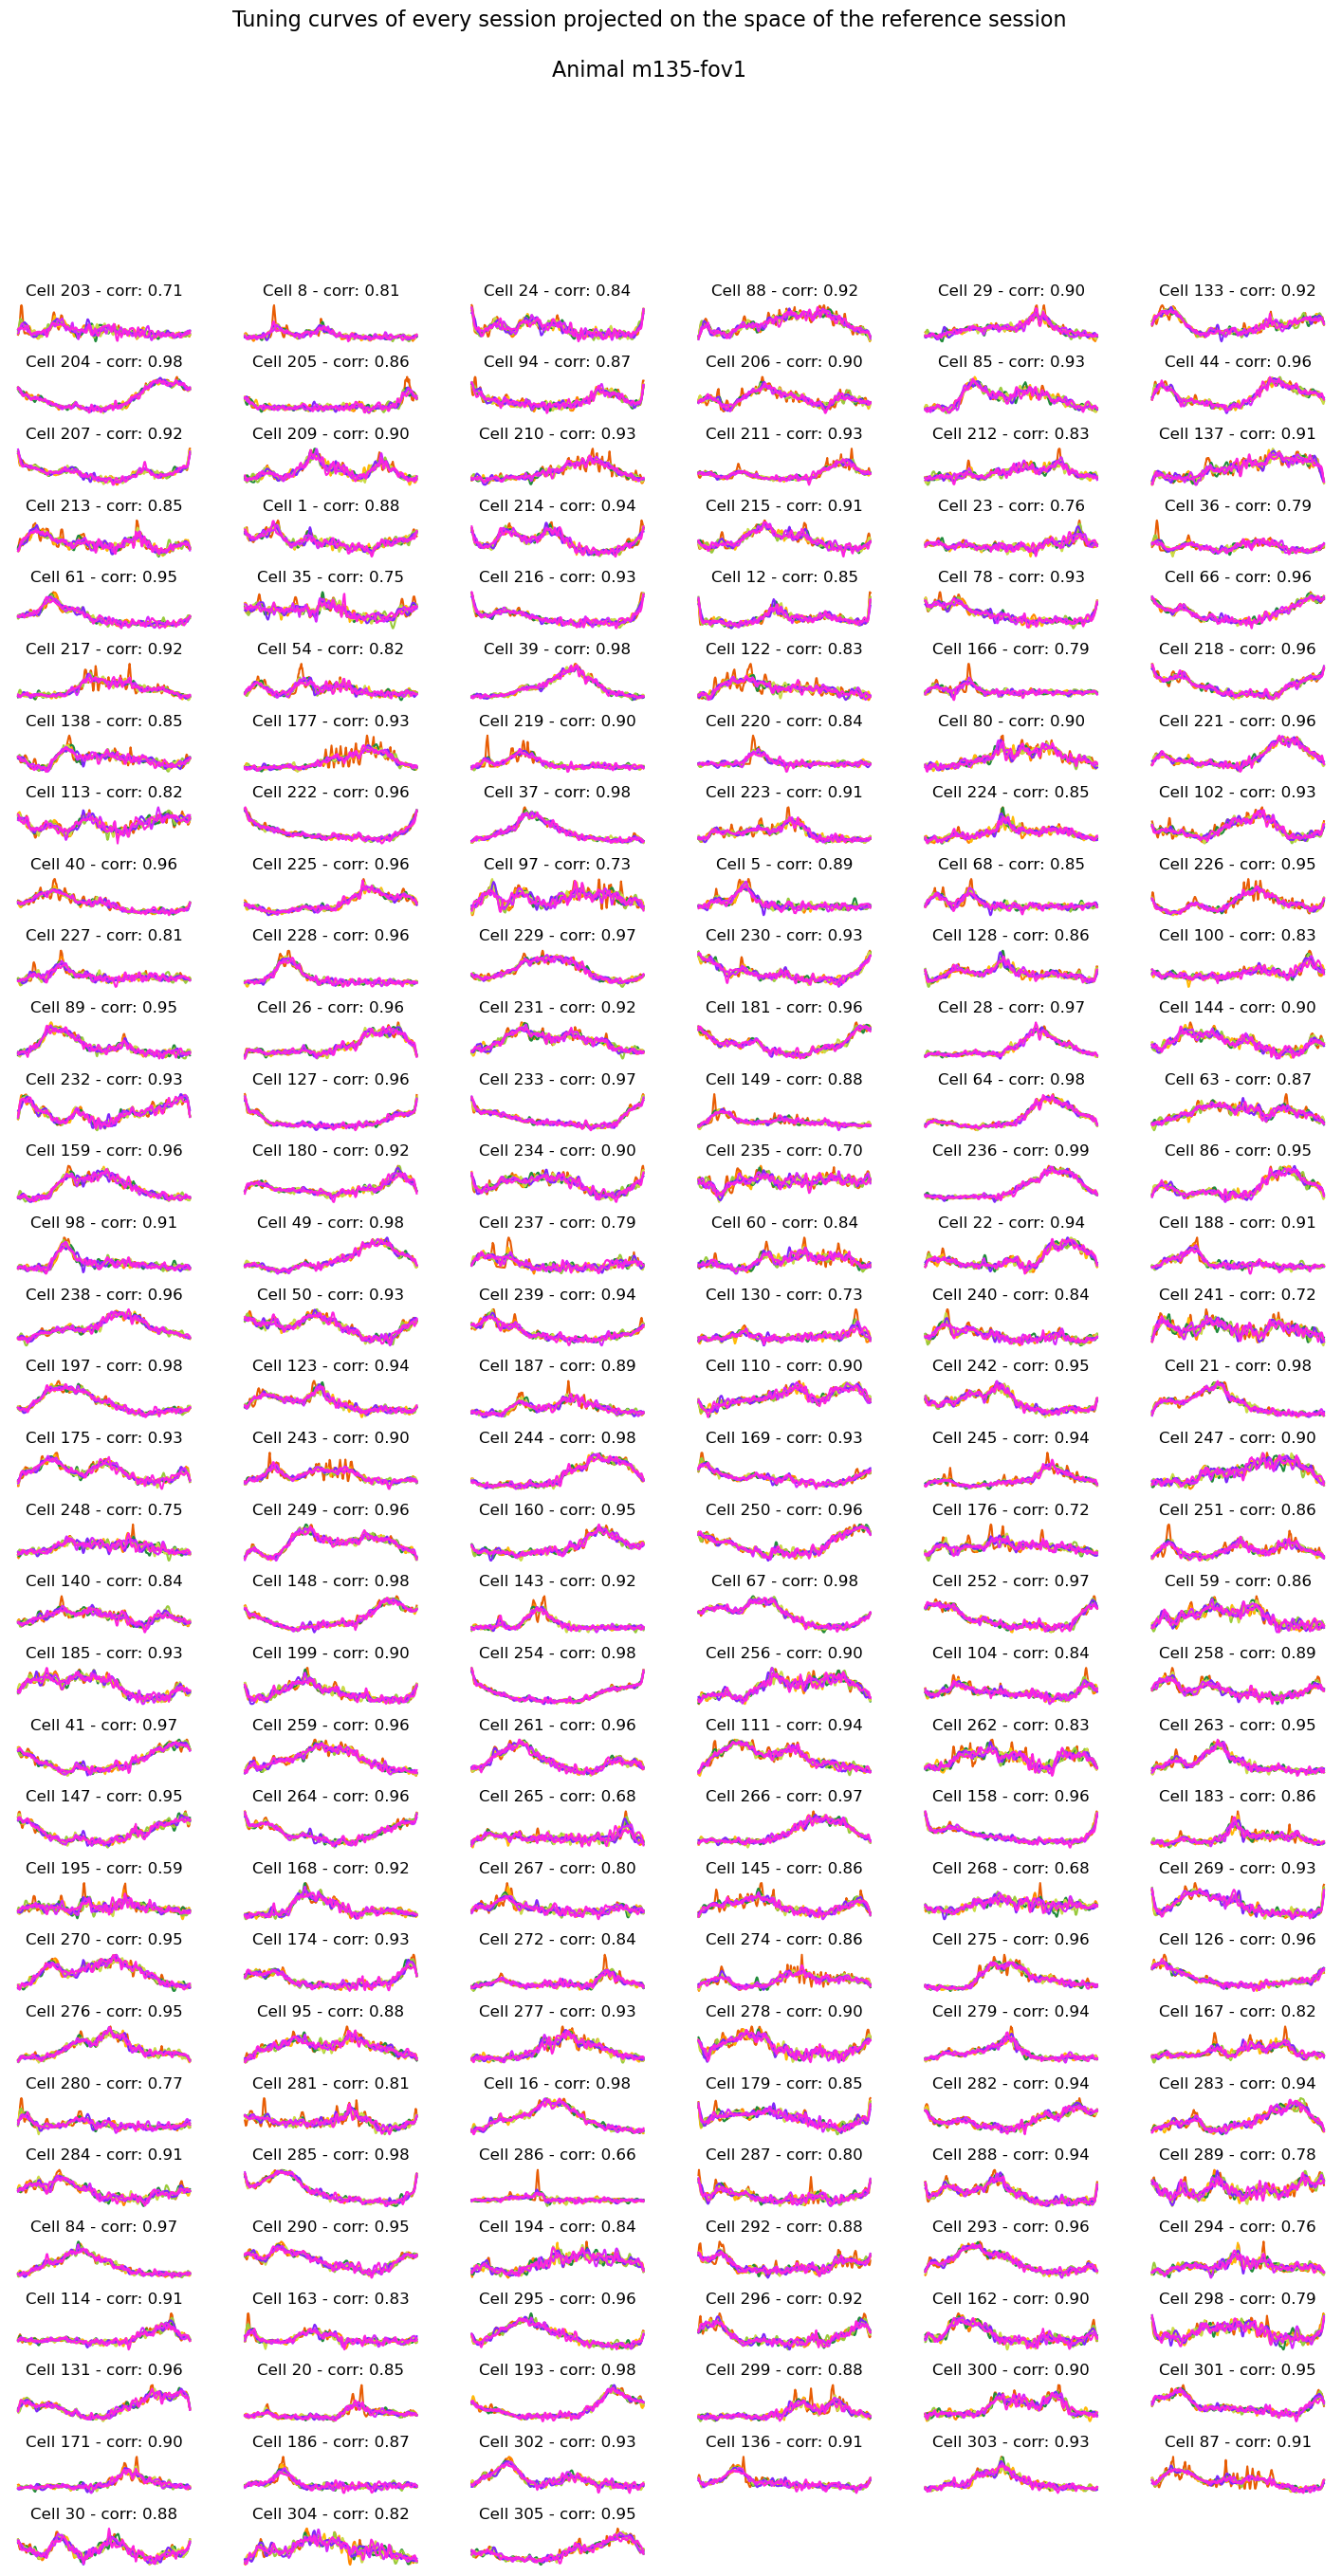

In [4]:
### Align the tuning curves to a reference session ###

# Smooth the tuning curves very little for better alignment
smoothed_tuning_curves = [
    smooth_tuning_curves_circularly(tuning_curves, 5)
    for tuning_curves in all_tuning_curves
]
# Take the first session as the reference
ref = 0
ref_tc = smoothed_tuning_curves[ref]
neurons = all_cells[ref]
print(f"Reference session with {ref_tc.shape[1]} neurons")
# Find its embedding
pca = PCA(n_components=20)  # Use 20 as it is around 80% of the variance
pca_ref_tc = pca.fit_transform(ref_tc)
pca_components = pca.components_
pca_means = np.mean(ref_tc, axis=0)
# Transform all the other tuning curves to the reference
aligned_tuning_curves = []
for i in range(len(sessions) - 1):
    tuning_curves = smoothed_tuning_curves[i + 1]
    pca_tc = pca.fit_transform(tuning_curves)
    A, _, _, _, cca_tc = canoncorr(pca_ref_tc, pca_tc, fullReturn=True)
    aligned_tuning_curves.append(
        (cca_tc @ np.linalg.inv(A) @ pca_components) + pca_means
    )
# Add the reference tuning curves at the beginning of the aligned tuning curves
all_aligned_tuning_curves = [ref_tc]
all_aligned_tuning_curves.extend(aligned_tuning_curves)

### Clean the aligned tuning curves ###

# Check if any tuning curve is flat
neurons_with_flat_tuning_curves = []
for tuning_curves in all_aligned_tuning_curves:
    for i, tuning_curve in enumerate(tuning_curves.T):
        if np.all(tuning_curve == tuning_curve[0]):
            neurons_with_flat_tuning_curves.append(i)
neurons_with_flat_tuning_curves = np.unique(neurons_with_flat_tuning_curves)
if len(neurons_with_flat_tuning_curves) > 0:
    # Remove neurons with flat tuning curves
    all_aligned_tuning_curves = [
        np.delete(tuning_curves, neurons_with_flat_tuning_curves, axis=1)
        for tuning_curves in all_aligned_tuning_curves
    ]
    print(
        f"... after removing flat tuning curves: {len(neurons_with_flat_tuning_curves)}"
    )
    neurons = np.delete(neurons, neurons_with_flat_tuning_curves)

### Plot the aligned tuning curves to the first session ###

# Smooth the tuning curves for plotting
smoothed_tuning_curves = [
    smooth_tuning_curves_circularly(tuning_curves, 5)
    for tuning_curves in all_aligned_tuning_curves
]
# Plot tuning curves of common neurons
n_cols = 6
colors = get_colors_for_each_experiment(sessions)
fig = plt.figure(figsize=(3 * n_cols, 1 * (len(neurons) // n_cols)))
grid = plt.GridSpec(
    nrows=np.ceil(len(neurons) / n_cols).astype(int),
    ncols=n_cols,
    figure=fig,
    wspace=0.2,
    hspace=0.8,
)
for n in range(len(neurons)):
    row = n // n_cols
    col = n % n_cols
    # save the tuning curves given the neuron to calculate their correlation
    tuning_curves = []
    ax = fig.add_subplot(grid[row, col])
    for s, session in enumerate(sessions):
        tuning_curves.append(smoothed_tuning_curves[s][:, n])
        ax.plot(
            np.arange(smoothed_tuning_curves[s].shape[0]),
            smoothed_tuning_curves[s][:, n],
            color=colors[s],
        )
    # find the correlation between the tuning curves
    correlations = []
    for i in range(len(tuning_curves)):
        for j in range(i + 1, len(tuning_curves)):
            corr = np.corrcoef(tuning_curves[i], tuning_curves[j])[0, 1]
            correlations.append(corr)
    ax.set_title(f"Cell {neurons[n]} - corr: {np.nanmean(correlations):.2f}")
    ax.set_axis_off()

fig.suptitle(
    f"Tuning curves of every session projected on the space of the reference session\n\nAnimal {animal}-{fov}",
    fontsize=16,
)
plt.savefig(f"{os.getcwd()}/plots/fig2b_2.pdf")
plt.savefig(f"{os.getcwd()}/plots/PNGs/fig2b_2.png", dpi=300)
plt.show()
# Save the data
with open(
    f"{grandparent_directory}/data/fig2/fig2b/{animal}_{fov}_post_alignment_tuning_curves_common_neurons.pkl",
    "wb",
) as f:
    pkl.dump(
        {
            "tuning_curves": smoothed_tuning_curves,
            "common_neurons": common_neurons,
            "sessions": sessions,
        },
        f,
    )